In [1]:
import os
import random
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

sns.set_style('ticks')
from pathlib import Path
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split         # Split data into train and test set
from sklearn.metrics import classification_report            # Summary of classifier performance

from utils import get_df, evaluate_classifier, numpy_confusion_matrix_to_pycm, save_confusion_matrix_fig 

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}

# Set global seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [2]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 183 ms


In [3]:
ds.close()

time: 18.7 ms


In [4]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 8.96 s


In [5]:
# Create the df format to be used by scikit-learn
for i, polarization in enumerate(['VV', 'VH', 'VV-VH']):
    df_polarization = get_df(polygons_year=2019, 
                             satellite_dates=slice('2018-01-01', '2019-12-31'), 
                             fields='all', 
                             satellite='all', 
                             polarization=polarization,
                             netcdf_path=netcdf_path)
    
    # Extract a mapping of field_ids to crop type
    if i == 0:
        df_sklearn = df_polarization[['field_id', 'afgkode', 'afgroede']]
    
    # Pivot the df (https://stackoverflow.com/a/37790707/12045808)
    df_polarization = df_polarization.pivot(index='field_id', columns='date', values='stats_mean')
    
    # Add polarization to column names
    df_polarization.columns = [str(col)[:10]+f'_{polarization}' for col in df_polarization.columns]  
    
    # Merge the polarization dataframes into one dataframe
    df_polarization = df_polarization.reset_index()  # Creates new indices and a 'field_id' column (field id was used as indices before)
    df_sklearn = pd.merge(df_sklearn, df_polarization, on='field_id') 
        
# Drop fields having nan values
df_sklearn = df_sklearn.dropna()

# The merge operation for some reason made duplicates (there was a bug reported on this earlier), so drop duplicates and re-index the df
df_sklearn = df_sklearn.drop_duplicates().reset_index(drop=True)

time: 28.3 s


In [6]:
df_sklearn_remapped = df_sklearn.copy()

df_sklearn_remapped.insert(3, 'Crop type', '')
df_sklearn_remapped.insert(4, 'Label ID', 0)
mapping_dict = {}
class_names = [] 
i = 0
for key, value in mapping_dict_crop_types.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
    if value not in class_names:
        class_names.append(value)
        mapping_dict[value] = i
        i += 1
    
for key, value in mapping_dict.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
print(f"Crop types: {class_names}")

Crop types: ['Potato', 'Spring barley', 'Winter barley', 'Spring wheat', 'Winter wheat', 'Winter rye', 'Spring oat', 'Maize', 'Rapeseed', 'Permanent grass', 'Willow', 'Forest']
time: 226 ms


In [29]:
array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,5:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int8(array[:,4])  # The column 'afgkode'

# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=RANDOM_SEED)

print(f"Train samples:      {len(y_train)}")
print(f"Test samples:       {len(y_test)}")
print(f"Number of features: {len(X[0,:])}")

Train samples:      31033
Test samples:       13300
Number of features: 231
time: 1.21 s


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression          
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

def get_classifiers(random_seed=42):
    # From https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
    # Note: GaussianClassifier does not work (maybe requires too much training - kernel restarts in jupyter)
    N_JOBS=4
    classifiers = { 
        #'Nearest Neighbors': GridSearchCV(KNeighborsClassifier(), 
        #                                  param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8]}, 
        #                                  refit=True, cv=5, n_jobs=N_JOBS),
        'Decision Tree': GridSearchCV(DecisionTreeClassifier(random_state=random_seed, class_weight='balanced'), 
                                      param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16]}, 
                                      refit=True, cv=5, n_jobs=N_JOBS),
        'Random Forest': GridSearchCV(RandomForestClassifier(random_state=random_seed, class_weight='balanced'), 
                                      param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16], 
                                                  'n_estimators': [6, 8, 10, 12, 14], 
                                                  'max_features': [1, 2, 3]},
                                      refit=True, cv=5, n_jobs=N_JOBS),
        'Logistic Regression': GridSearchCV(LogisticRegression(max_iter=1000, random_state=random_seed, class_weight='balanced'),
                                            param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2],
                                                        'penalty': ['none', 'l2']},
                                            refit=True, cv=5, n_jobs=N_JOBS),
        'Linear SVM': GridSearchCV(SVC(kernel='linear', random_state=random_seed, class_weight='balanced'),
                                   #param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]},
                                   param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]},
                                   refit=True, cv=5, n_jobs=N_JOBS),
        'RBF SVM': GridSearchCV(SVC(kernel='rbf', random_state=random_seed, class_weight='balanced'),
                                #param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]},
                                param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]},
                                refit=True, cv=5, n_jobs=N_JOBS),
        'Neural Network': GridSearchCV(MLPClassifier(max_iter=1000, random_state=random_seed),
                                       param_grid={'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
                                                   'hidden_layer_sizes': [(50,50,50), (100, 100, 100), (100,)],
                                                   'activation': ['tanh', 'relu'],
                                                   'learning_rate': ['constant','adaptive']},
                                       refit=True, cv=5, n_jobs=N_JOBS)
        }
    
    return classifiers

time: 23.8 ms


In [31]:
df_clf_results = pd.DataFrame(columns=['Classifier', 'Crop type', 'Prec.', 'Recall', 
                                       'F1-Score', 'Accuracy', 'Samples', 'Random seed'])

clf_trained_dict = {}
report_dict = {}
cm_dict = {}

# TODO: Also calculate uncertainties - ie. use multiple random seeds.
#       Create df (with cols [Clf_name, Random_seed, Acc., Prec., Recall, F1-score]) and loop over random seeds
#       See following on how to format pandas dataframe to get the uncertainties into the df
#       https://stackoverflow.com/questions/46584736/pandas-change-between-mean-std-and-plus-minus-notations
for random_seed in range(10):
    print(f"\n\n################################## RANDOM SEED IS SET TO {random_seed:2d} ##################################") 
    # Seed the random generators
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    
    # Get the train and test sets with the specified random_seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=random_seed)
    
    # Get the classifiers
    classifiers = get_classifiers(random_seed)
    
    for name, clf in classifiers.items():
        # Evaluate classifier
        print("-------------------------------------------------------------------------------")
        print(f"Evaluating classifier: {name}")
        clf_trained, _, _, results_report, cnf_matrix = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                            feature_scale=True, plot_conf_matrix=False,
                                                                            print_classification_report=False)      
        print(f"The best parameters are {clf_trained.best_params_} with a score of {clf_trained.best_score_:2f}")

        # Save results in dicts
        clf_trained_dict[f'{name}_random_seed_{random_seed:02}'] = clf_trained
        report_dict[f'{name}_random_seed_{random_seed:02}'] = results_report
        cm_dict[f'{name}_random_seed_{random_seed:02}'] = cnf_matrix
        
        # Save results for individual crops in df
        df_results = pd.DataFrame(results_report).transpose()  
        for crop_type in class_names:
            # Get values
            prec = df_results.loc[crop_type, 'precision']
            recall = df_results.loc[crop_type, 'recall']
            f1 = df_results.loc[crop_type, 'f1-score']
            samples = df_results.loc[crop_type, 'support']
            acc = None

            # Insert row in df (https://stackoverflow.com/a/24284680/12045808)
            df_clf_results.loc[-1] = [name, crop_type, prec, recall, f1, acc, samples, random_seed]
            df_clf_results.index = df_clf_results.index + 1  # shifting index
            df_clf_results = df_clf_results.sort_index()  # sorting by index

        # Save overall results
        prec = df_results.loc['weighted avg', 'precision']
        recall = df_results.loc['weighted avg', 'recall']
        f1 = df_results.loc['weighted avg', 'f1-score']
        acc = df_results.loc['accuracy', 'f1-score']
        samples = df_results.loc['weighted avg', 'support']

        # Insert row in df (https://stackoverflow.com/a/24284680/12045808)
        df_clf_results.loc[-1] = [name, 'Overall', prec, recall, f1, acc, samples, random_seed]
        df_clf_results.index = df_clf_results.index + 1  # shifting index
        df_clf_results = df_clf_results.sort_index()  # sorting by index

        # Save df with results to disk
        save_path = PROJ_PATH / 'notebooks' / '03_TrainClassifiers_results.pkl'
        df_clf_results.to_pickle(save_path)



################################## RANDOM SEED IS SET TO  0 ##################################
-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 69.8332 s
Prediction time: 0.0073 s

Report:

Train accuracy: 0.9357
Test accuracy: 0.865
The best parameters are {'max_depth': 12} with a score of 0.862791
-------------------------------------------------------------------------------
Evaluating classifier: Random Forest
Training time: 97.2482 s
Prediction time: 0.0404 s

Report:

Train accuracy: 0.9879
Test accuracy: 0.9016
The best parameters are {'max_depth': 16, 'max_features': 3, 'n_estimators': 14} with a score of 0.901331
-------------------------------------------------------------------------------
Evaluating classifier: Logistic Regression
Training time: 614.48 s
Prediction time: 0.0079 s

Report:

Train accuracy: 0.9296
Test accuracy: 0.9222
The best parameters are {'C': 0.01, 'penalty': 'l2'} with

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training time: 2746.1201 s
Prediction time: 99.3342 s

Report:

Train accuracy: 0.9646
Test accuracy: 0.9408
The best parameters are {'C': 1} with a score of 0.939355
-------------------------------------------------------------------------------
Evaluating classifier: Neural Network
Training time: 6226.1319 s
Prediction time: 0.0222 s

Report:

Train accuracy: 0.9471
Test accuracy: 0.9374
The best parameters are {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant'} with a score of 0.934876


################################## RANDOM SEED IS SET TO  1 ##################################
-------------------------------------------------------------------------------
Evaluating classifier: Decision Tree
Training time: 68.422 s
Prediction time: 0.0081 s

Report:

Train accuracy: 0.9604
Test accuracy: 0.868
The best parameters are {'max_depth': 14} with a score of 0.860632
-------------------------------------------------------------------------

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training time: 3149.9072 s
Prediction time: 35.3898 s

Report:

Train accuracy: 0.9656
Test accuracy: 0.9394
The best parameters are {'C': 1} with a score of 0.938453
-------------------------------------------------------------------------------
Evaluating classifier: Neural Network
Training time: 6427.3582 s
Prediction time: 0.0428 s

Report:

Train accuracy: 0.9468
Test accuracy: 0.9341
The best parameters are {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant'} with a score of 0.935521
time: 6h 19min 57s


In [22]:
# Load the df with results from saved file
load_path = PROJ_PATH / 'notebooks' / '03_TrainClassifiers_results.pkl'
df_clf_results = pd.read_pickle(load_path)

time: 35.6 ms


In [24]:
df_clf_results.head(5)

,Classifier,Crop type,Prec.,Recall,F1-Score,Accuracy,Samples,Random seed
0,Random Forest,Overall,0.90,0.90,0.90,0.90,13300.00,1
1,Random Forest,Forest,0.90,0.87,0.89,None,388.00,1
2,Random Forest,Willow,0.83,0.74,0.78,None,251.00,1
3,Random Forest,Permanent grass,0.82,0.91,0.86,None,1135.00,1
4,Random Forest,Rapeseed,1.00,0.99,0.99,None,1121.00,1


time: 40 ms


In [26]:
# Create df with results from classifiers and create latex table with them
df_clf_results = pd.DataFrame(columns=['Name', 'Acc.', 'Prec.', 'Recall', 'F1-Score'])
for name, results_report in report_dict.items():
    df_results = pd.DataFrame(report_dict[name]).transpose()  
    prec = df_results.loc['weighted avg', 'precision']
    recall = df_results.loc['weighted avg', 'recall']
    f1 = df_results.loc['weighted avg', 'f1-score']
    acc = df_results.loc['accuracy', 'f1-score']
    
    # Insert row in df (https://stackoverflow.com/a/24284680/12045808)
    df_clf_results.loc[-1] = [name, acc, prec, recall, f1]
    df_clf_results.index = df_clf_results.index + 1  # shifting index
    df_clf_results = df_clf_results.sort_index()  # sorting by index
    
# Print df in latex format
pd.options.display.float_format = '{:.2f}'.format  # Show 2 decimals
print(df_clf_results.sort_index(ascending=False).to_latex(index=False))  

\begin{tabular}{lrrrr}
\toprule
                         Name &  Acc. &  Prec. &  Recall &  F1-Score \\
\midrule
 Decision Tree\_random\_seed\_00 &  0.87 &   0.87 &    0.87 &      0.87 \\
 Random Forest\_random\_seed\_00 &  0.91 &   0.90 &    0.91 &      0.90 \\
 Decision Tree\_random\_seed\_01 &  0.86 &   0.87 &    0.86 &      0.87 \\
 Random Forest\_random\_seed\_01 &  0.90 &   0.90 &    0.90 &      0.90 \\
\bottomrule
\end{tabular}

time: 57.6 ms


In [10]:
# Show performance on different classes with best performing classifier
# Get classfication report as pandas df
df_results = pd.DataFrame(report_dict['RBF SVM']).transpose()  

# Round the values to 2 decimals
df_results = df_results.astype({'support': 'int32'}).round(2) 

# Remove samples from 'macro avg' and 'weighed avg'
df_results.loc[df_results.index == 'accuracy', 'precision'] = ''  
df_results.loc[df_results.index == 'accuracy', 'recall'] = ''  
df_results.loc[df_results.index == 'accuracy', 'support'] = df_results.loc[df_results.index == 'macro avg', 'support'].values

# Rename the support column to 'samples'
df_results = df_results.rename(columns={'precision': 'Prec.',
                                        'recall': 'Recall',
                                        'f1-score': 'F1-score',
                                        'support': 'Samples'},
                               index={'accuracy': 'Overall acc.',
                                      'macro avg': 'Macro avg.',
                                      'weighted avg': 'Weighted avg.'})


# Print df in latex format (I normally add a /midrule above 'Macro avg.' and delete 'Overall acc.')
pd.options.display.float_format = '{:.2f}'.format  # Show 2 decimals
print(df_results.to_latex(index=True))  

\begin{tabular}{lllrr}
\toprule
{} & Prec. & Recall &  F1-score &  Samples \\
\midrule
Potato          &  0.98 &   0.98 &      0.98 &     2251 \\
Spring barley   &  0.90 &   0.91 &      0.90 &     1187 \\
Winter barley   &  0.99 &   0.98 &      0.98 &     1311 \\
Spring wheat    &  0.74 &   0.71 &      0.72 &      482 \\
Winter wheat    &  0.92 &   0.97 &      0.94 &     1114 \\
Winter rye      &  0.96 &   0.96 &      0.96 &     1290 \\
Spring oat      &  0.93 &   0.86 &      0.89 &     1340 \\
Maize           &  0.97 &   0.98 &      0.98 &     1430 \\
Rapeseed        &  1.00 &   0.99 &      1.00 &     1121 \\
Permanent grass &  0.90 &   0.95 &      0.92 &     1135 \\
Willow          &  0.85 &   0.90 &      0.87 &      251 \\
Forest          &  0.91 &   0.87 &      0.89 &      388 \\
Overall acc.    &       &        &      0.94 &    13300 \\
Macro avg.      &  0.92 &   0.92 &      0.92 &    13300 \\
Weighted avg.   &  0.94 &   0.94 &      0.94 &    13300 \\
\bottomrule
\end{tabular}

t

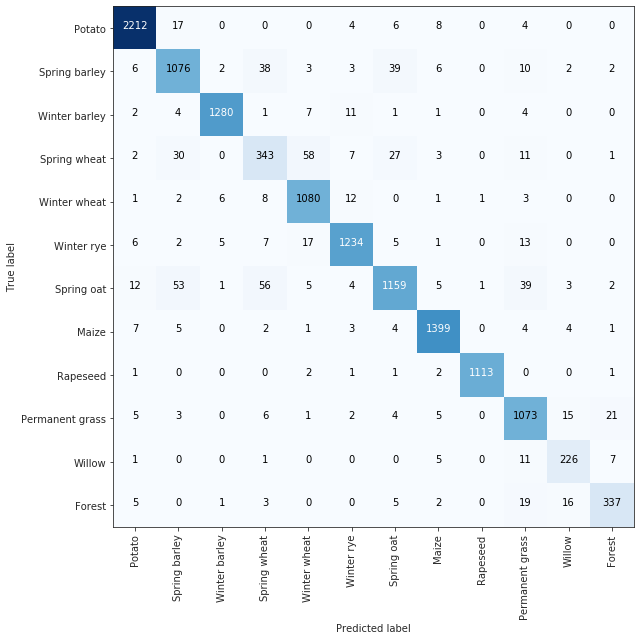

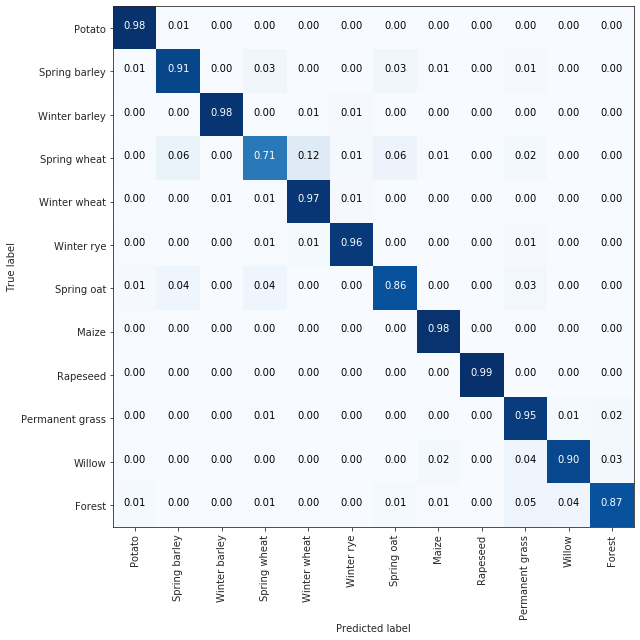

time: 1.55 s


In [11]:
# Save the confusion matrix figure you want
plot_name = 'RBF_SVM_conf_matrix'
plot_path = PROJ_PATH / 'reports' / 'figures' / 'conf_matrices' / plot_name
if not plot_path.parent.exists():
    plot_path.parent.mkdir()
    
save_confusion_matrix_fig(cm_dict['RBF SVM'], classes=class_names, save_path=plot_path)
save_confusion_matrix_fig(cm_dict['RBF SVM'], classes=class_names, save_path=plot_path, normalized=True)